In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

from qiskit import  BasicAer, Aer, execute, QuantumCircuit
from qiskit.quantum_info.operators import Operator
backend = Aer.get_backend("qasm_simulator")

from qiskit.visualization import plot_histogram

In [2]:
# QFT

def phase_rotate(circuit, n):  
    if n == 0: return circuit    
    n = n-1
    circuit.h(n)    
    for qubit in range(n): circuit.cp(np.pi/2**(n-qubit), qubit, n)     
    phase_rotate(circuit, n)

def swap_registers(circuit, n):    
    for qubit in range(n//2): circuit.swap(qubit, n-qubit-1)
        
def qft(circuit, n, where):
    qc = QuantumCircuit(n)
    phase_rotate(qc,n)
    swap_registers(qc,n)
    qft = qc.to_gate()
    qft.name = " QFT "
    circuit.append(qft, range(where,n+where))

def qft_dagger(circuit, n, where):
    qc = QuantumCircuit(n)
    phase_rotate(qc,n)
    swap_registers(qc,n)
    
    qc_dagger = qc.inverse()
    qft_dagger = qc_dagger.to_gate()
    qft_dagger.name = " QFT$^\dagger$ "
    circuit.append(qft_dagger, range(where,n+where))

#### Ex1.

$A = \begin{bmatrix}1 & -\frac{1}{3} \\-\frac{1}{3} & 1\end{bmatrix}$, $b = \begin{bmatrix}1\\0\end{bmatrix}\longrightarrow  x = \begin{bmatrix}1.125\\0.375\end{bmatrix}$

$U = e^{iAt}$, where $t = \frac{2\pi\widetilde{\lambda}}{2^n\lambda} = \frac{3}{4}\pi$

$\widetilde{\lambda_1} = |01\rangle = |1\rangle \longrightarrow \theta_1 = 2{sin}^{-1}(\frac{1}{1}) = \pi$

$\widetilde{\lambda_2} = |10\rangle = |2\rangle \longrightarrow \theta_2 = 2{sin}^{-1}(\frac{1}{2}) = \frac{\pi}{3}$

In [3]:
matrix = np.array([[1, -1/3], [-1/3, 1]])
vector = np.array([1, 0])

classic_solution = np.linalg.solve(matrix, vector)
norm = np.linalg.norm(classic_solution)
eigenvals,eigenvecs=np.linalg.eig(matrix)
print("sol:",classic_solution)
print("Eigenvalues:",eigenvals)
print("Eigenvectors:",eigenvecs)
print("Euclidean norm:",norm)

sol: [1.125 0.375]
Eigenvalues: [1.33333333 0.66666667]
Eigenvectors: [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
Euclidean norm: 1.1858541225631423


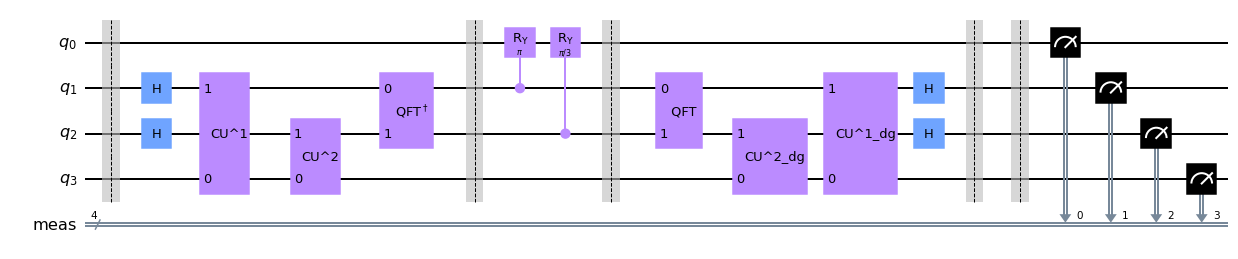

In [4]:
t = (3/4)*np.pi

def CU(A,num):
    qc = QuantumCircuit(2)
    U_A, C_U = np.eye(2, dtype='complex'), np.eye(4, dtype='complex')
    for i in range(num): U_A = U_A.dot(expm(1j*A*t))
    C_U[2:4,2:4] = U_A 

    qc.unitary(Operator(C_U), range(2))
    CU_gate = qc.to_gate()
    CU_gate.name = "CU^{}".format(num)
    return CU_gate

qc = QuantumCircuit(4)
# qc.x(3)

qc.barrier()

qc.h([1,2])
qc.append(CU(matrix,1),[3,1])
qc.append(CU(matrix,2),[3,2])


qft_dagger(qc,2,1)
qc.barrier()

qc.cry(2*np.arcsin(1/1),1,0)
qc.cry(2*np.arcsin(1/2),2,0)
qc.barrier()

qft(qc,2,1)
qc.append(CU(matrix,2).inverse(),[3,2])
qc.append(CU(matrix,1).inverse(),[3,1])
qc.h([1,2])

qc.save_statevector()
qc.measure_all()

qc.draw(output="mpl",fold=-1)

solution: [1.125 0.375]


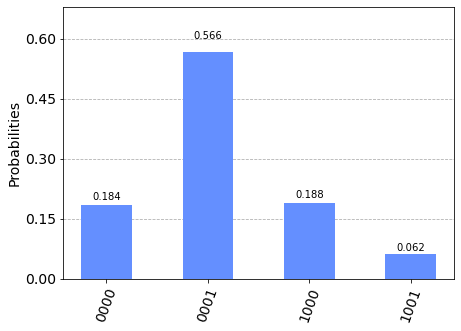

In [5]:
result = execute(qc, backend=backend, shots=4096, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[1], sv[9]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())

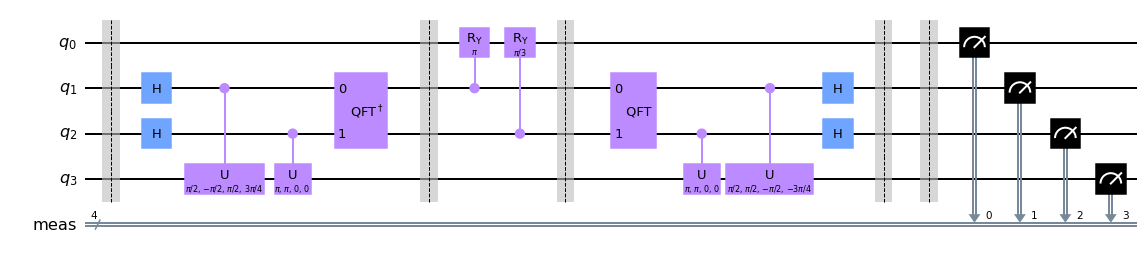

In [6]:
t = (3/4)*np.pi

from qiskit.circuit.library import CUGate
qc = QuantumCircuit(4)
# qc.x(3)

qc.barrier()

qc.h([1,2])
qc.append(CUGate(np.pi/2,-np.pi/2,np.pi/2,(3/4)*np.pi),[1,3])
qc.append(CUGate(np.pi,np.pi,0,0),[2,3])

qft_dagger(qc,2,1)
qc.barrier()


qc.cry(2*np.arcsin(1/1),1,0)
qc.cry(2*np.arcsin(1/2),2,0)
qc.barrier()

qft(qc,2,1)
qc.append(CUGate(np.pi,np.pi,0,0),[2,3])
qc.append(CUGate(np.pi/2,np.pi/2,-np.pi/2,(-3/4)*np.pi),[1,3])
qc.h([1,2])

qc.save_statevector()
qc.measure_all()

qc.draw(output="mpl",fold=-1)

solution: [1.125 0.375]


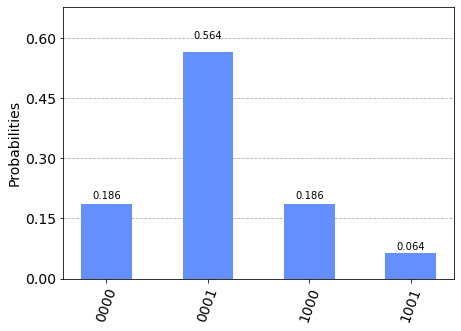

In [7]:
result = execute(qc, backend=backend, shots=4096, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[1], sv[9]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())

#### Qiskit built-in HHL algorithm

In [8]:
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector

hhl_qc = HHL().construct_circuit(matrix, vector)
hhl_qc.save_statevector()
hhl_qc.measure_all()
hhl_qc.decompose().draw(fold=-1)

# hhl_solution = HHL().solve(matrix, vector)
# print('Euclidean norm:', hhl_solution.euclidean_norm)
# sv = Statevector(hhl_solution.state).data
# full_vector = np.real(np.array([sv[16], sv[17]]))
# print('solution:', hhl_solution.euclidean_norm*full_vector/np.linalg.norm(full_vector))

┌──────────┐┌──────┐        ┌─────────┐ ░  ░ ┌─┐            
   q38: ┤ Isometry ├┤3     ├────────┤3        ├─░──░─┤M├────────────
        └──────────┘│      │┌──────┐│         │ ░  ░ └╥┘┌─┐         
 q39_0: ────────────┤0     ├┤2     ├┤0        ├─░──░──╫─┤M├─────────
                    │  QPE ││      ││  QPE_dg │ ░  ░  ║ └╥┘┌─┐      
 q39_1: ────────────┤1     ├┤1     ├┤1        ├─░──░──╫──╫─┤M├──────
                    │      ││  1/x ││         │ ░  ░  ║  ║ └╥┘┌─┐   
 q39_2: ────────────┤2     ├┤0     ├┤2        ├─░──░──╫──╫──╫─┤M├───
                    └──────┘│      │└─────────┘ ░  ░  ║  ║  ║ └╥┘┌─┐
   q40: ────────────────────┤3     ├────────────░──░──╫──╫──╫──╫─┤M├
                            └──────┘            ░  ░  ║  ║  ║  ║ └╥┘
meas: 5/══════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                      0  1  2  3  4

Euclidean norm: 1.1858541225631387
solution: [1.125 0.375]


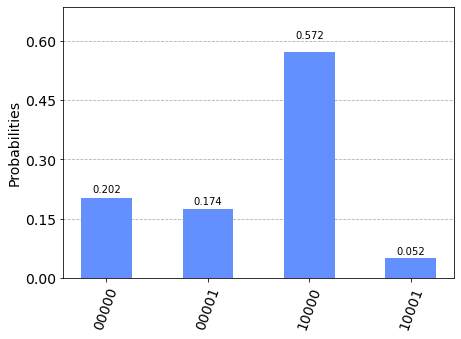

In [9]:
hhl_solution = HHL().solve(matrix, vector)
print('Euclidean norm:', hhl_solution.euclidean_norm)

result = execute(hhl_qc, backend=backend, shots=4096, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[16], sv[17]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())

#### Ex2.  

$A = \begin{bmatrix}15&9&5&-3\\9&15&3&-5\\5&3&15&-9\\-3&-5&-9&15\end{bmatrix}$, $b = \begin{bmatrix}0\\0\\0\\1\end{bmatrix}\longrightarrow  x = \begin{bmatrix}-0.09375\\0.15625\\0.28125\\0.46875\end{bmatrix}$

$U = e^{iAt}$, where $t = \frac{2\pi\widetilde{\lambda}}{2^n\lambda} = \frac{1}{8}\pi$

$\widetilde{\lambda_1} = |0001\rangle = |1\rangle \longrightarrow \theta_1 = 2{sin}^{-1}(\frac{1}{1}) = \pi$

$\widetilde{\lambda_2} = |0010\rangle = |2\rangle \longrightarrow \theta_2 = 2{sin}^{-1}(\frac{1}{2}) = \frac{\pi}{3}$

$\widetilde{\lambda_3} = |0100\rangle = |4\rangle \longrightarrow \theta_3 = 2{sin}^{-1}(\frac{1}{4})$

$\widetilde{\lambda_4} = |1000\rangle = |8\rangle \longrightarrow \theta_4 = 2{sin}^{-1}(\frac{1}{8})$

In [10]:
matrix = (1/4)*np.array([[15, 9, 5,-3],
                         [ 9,15, 3,-5],
                         [ 5, 3,15,-9],
                         [-3,-5,-9,15]])
vector = np.array([0, 0, 0, 1])

classic_solution = np.linalg.solve(matrix, vector)
norm = np.linalg.norm(classic_solution)
eigenvals,eigenvecs=np.linalg.eig(matrix)
print("sol:",classic_solution)
print("Eigenvalues:",eigenvals)
print("Eigenvectors:",eigenvecs)
print("Euclidean norm:",norm)

sol: [-0.09375  0.15625  0.28125  0.46875]
Eigenvalues: [8. 4. 1. 2.]
Eigenvectors: [[ 0.5  0.5  0.5  0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]
 [-0.5  0.5 -0.5  0.5]]
Euclidean norm: 0.5762215285808053


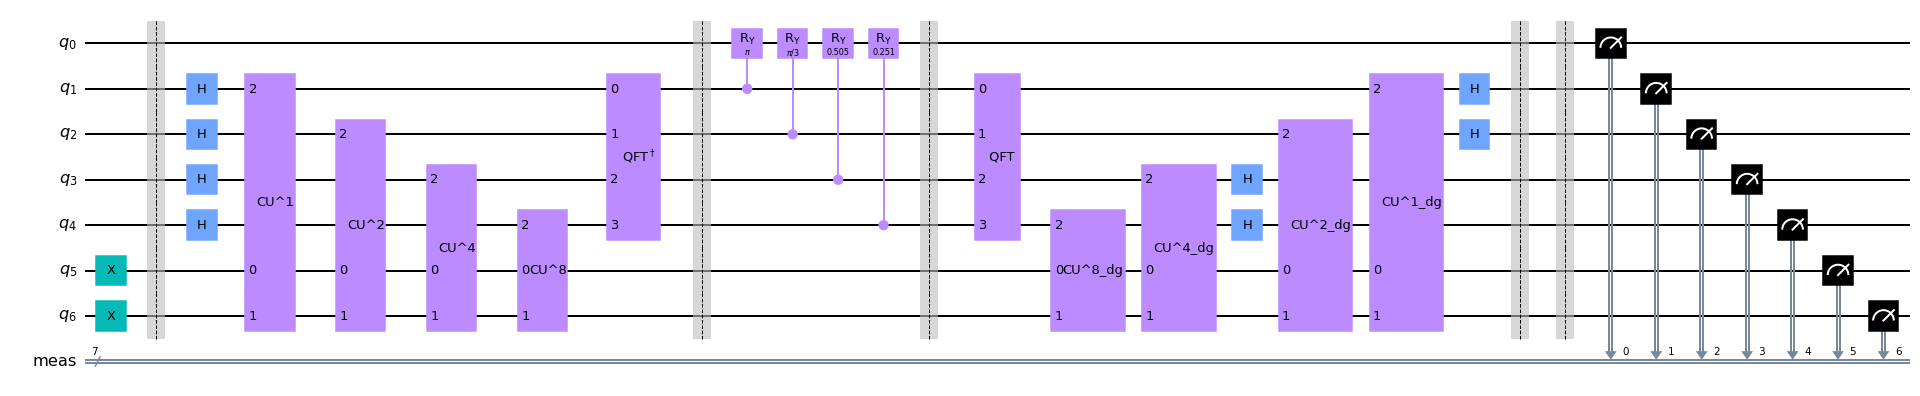

In [11]:
t = (1/8)*np.pi

def CU(A,num):
    qc = QuantumCircuit(3)
    U_A, C_U = np.eye(4, dtype='complex'), np.eye(8, dtype='complex')
    for i in range(num): U_A = U_A.dot(expm(1j*A*t))
    C_U[4:8,4:8] = U_A 

    qc.unitary(Operator(C_U), range(3))
    CU_gate = qc.to_gate()
    CU_gate.name = "CU^{}".format(num)
    return CU_gate

qc = QuantumCircuit(7)
qc.x([5,6])

qc.barrier()

qc.h([1,2,3,4])
rep = 1
for i in range(4):
    qc.append(CU(matrix,rep),[5,6,i+1])
    rep*=2
  
qft_dagger(qc,4,1)
qc.barrier()

qc.cry(2*np.arcsin(1/1),1,0)
qc.cry(2*np.arcsin(1/2),2,0)
qc.cry(2*np.arcsin(1/4),3,0)
qc.cry(2*np.arcsin(1/8),4,0)
qc.barrier()

qft(qc,4,1)
rep = 8
for i in range(4):
    qc.append(CU(matrix,int(rep)).inverse(),[5,6,4-i])
    rep/=2 
qc.h([1,2,3,4])

qc.save_statevector()
qc.measure_all()

qc.draw(output="mpl",fold=-1)

solution: [-0.09375  0.15625  0.28125  0.46875]


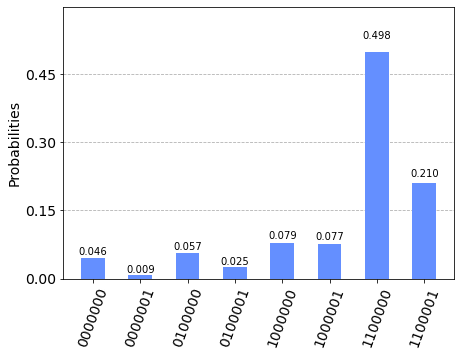

In [12]:
result = execute(qc, backend=backend, shots=4096, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[1], sv[33], sv[65], sv[97]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())

#### Qiskit built-in HHL algorithm

In [13]:
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector

hhl_qc = HHL().construct_circuit(matrix, vector)
hhl_qc.save_statevector()
hhl_qc.measure_all()
hhl_qc.decompose().draw(fold=-1)

┌───────────┐┌──────┐        ┌─────────┐ ░  ░ ┌─┐                     
q128_0: ┤0          ├┤5     ├────────┤5        ├─░──░─┤M├─────────────────────
        │  Isometry ││      │        │         │ ░  ░ └╥┘┌─┐                  
q128_1: ┤1          ├┤6     ├────────┤6        ├─░──░──╫─┤M├──────────────────
        └───────────┘│      │┌──────┐│         │ ░  ░  ║ └╥┘┌─┐               
q129_0: ─────────────┤0     ├┤4     ├┤0        ├─░──░──╫──╫─┤M├───────────────
                     │      ││      ││         │ ░  ░  ║  ║ └╥┘┌─┐            
q129_1: ─────────────┤1 QPE ├┤3     ├┤1 QPE_dg ├─░──░──╫──╫──╫─┤M├────────────
                     │      ││      ││         │ ░  ░  ║  ║  ║ └╥┘┌─┐         
q129_2: ─────────────┤2     ├┤2     ├┤2        ├─░──░──╫──╫──╫──╫─┤M├─────────
                     │      ││  1/x ││         │ ░  ░  ║  ║  ║  ║ └╥┘┌─┐      
q129_3: ─────────────┤3     ├┤1     ├┤3        ├─░──░──╫──╫──╫──╫──╫─┤M├──────
                     │      ││      ││         │ ░  ░  ║  ║  ║  ║  ║ └╥┘┌─┐   
q129_4: ─────────────┤4     ├┤0     ├┤4        ├─░──░──╫──╫──╫──╫──╫──╫─┤M├───
                     └──────┘│      │└─────────┘ ░  ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
  q130: ─────────────────────┤5     ├────────────░──░──╫──╫──╫──╫──╫──╫──╫─┤M├
                             └──────┘            ░  ░  ║  ║  ║  ║  ║  ║  ║ └╥┘
meas: 8/═══════════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
                                                       0  1  2  3  4  5  6  7

solution: [-0.09375  0.15625  0.28125  0.46875]


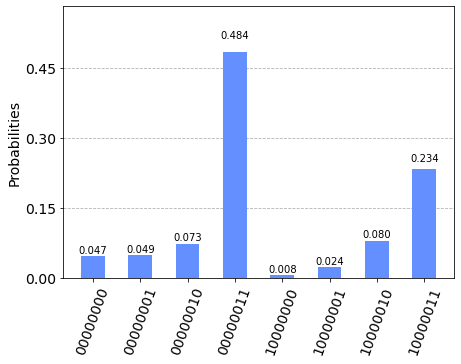

In [14]:
result = execute(hhl_qc, backend=backend, shots=4096, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[128], sv[129], sv[130], sv[131]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())

#### Ex3.

$A = \begin{bmatrix}1 & 2 \\-2&2\end{bmatrix}$, $b = \begin{bmatrix}0\\1\end{bmatrix}\longrightarrow  x = \begin{bmatrix}-0.333\\1.667\end{bmatrix}$


In [15]:
matrix = np.array([[1, 2], [-2, 2]])
vector = np.array([0 ,1])

classic_solution = np.linalg.solve(matrix, vector)
norm = np.linalg.norm(classic_solution)
eigenvals,eigenvecs=np.linalg.eig(matrix)
print("sol:",classic_solution)
print("Eigenvalues:",eigenvals)
print("Eigenvectors:",eigenvecs)
print("Euclidean norm:",norm)

sol: [-0.33333333  0.16666667]
Eigenvalues: [1.5+1.93649167j 1.5-1.93649167j]
Eigenvectors: [[0.70710678+0.j        0.70710678-0.j       ]
 [0.1767767 +0.6846532j 0.1767767 -0.6846532j]]
Euclidean norm: 0.37267799624996495


Note that $A$ is not Hermitian, we enlarge the matrix:

$\widetilde{A}=\begin{bmatrix}0&0&1&-2\\0&0&2&2\\1&2&0&0\\-2&2&0&0\end{bmatrix}$, $|\widetilde{b}\rangle = |1\rangle \otimes|b\rangle=\begin{bmatrix}0\\0\\0\\1\end{bmatrix}\longrightarrow  |\widetilde{x}\rangle =|0\rangle \otimes|x\rangle= \begin{bmatrix}-0.333\\1.667\\0\\0\end{bmatrix}$

$U = e^{iAt}$, where $t = \frac{2\pi\widetilde{\lambda}}{2^n\lambda} = \frac{1}{8}\pi$

$\widetilde{\lambda_1} = |0011\rangle = |2\rangle \longrightarrow \theta_1 = 2{sin}^{-1}(1)$

$\widetilde{\lambda_2} = |0010\rangle = |3\rangle \longrightarrow \theta_2 = 2{sin}^{-1}(\frac{2}{3})$

$\widetilde{\lambda_3} = -|0010\rangle = -|3\rangle \longrightarrow \theta_3 = 2{sin}^{-1}(-\frac{2}{3})$

$\widetilde{\lambda_4} = -|0011\rangle = -|2\rangle \longrightarrow \theta_4 = 2{sin}^{-1}(-1)$

In [16]:
matrix = np.array([[0, 0, 1, -2],
                   [0, 0, 2, 2],
                   [1, 2, 0, 0],
                   [-2, 2, 0, 0]])
vector = np.array([0, 0, 0, 1])

classic_solution = np.linalg.solve(matrix, vector)
norm = np.linalg.norm(classic_solution)
eigenvals,eigenvecs=np.linalg.eig(matrix)
print("sol:",classic_solution)
print("Eigenvalues:",eigenvals)
print("Eigenvectors:",eigenvecs)
print("Euclidean norm:",norm)

sol: [-0.33333333  0.16666667  0.         -0.        ]
Eigenvalues: [-3. -2.  2.  3.]
Eigenvectors: [[-0.31622777  0.63245553  0.63245553 -0.31622777]
 [ 0.63245553  0.31622777  0.31622777  0.63245553]
 [-0.31622777 -0.63245553  0.63245553  0.31622777]
 [-0.63245553  0.31622777 -0.31622777  0.63245553]]
Euclidean norm: 0.37267799624996495


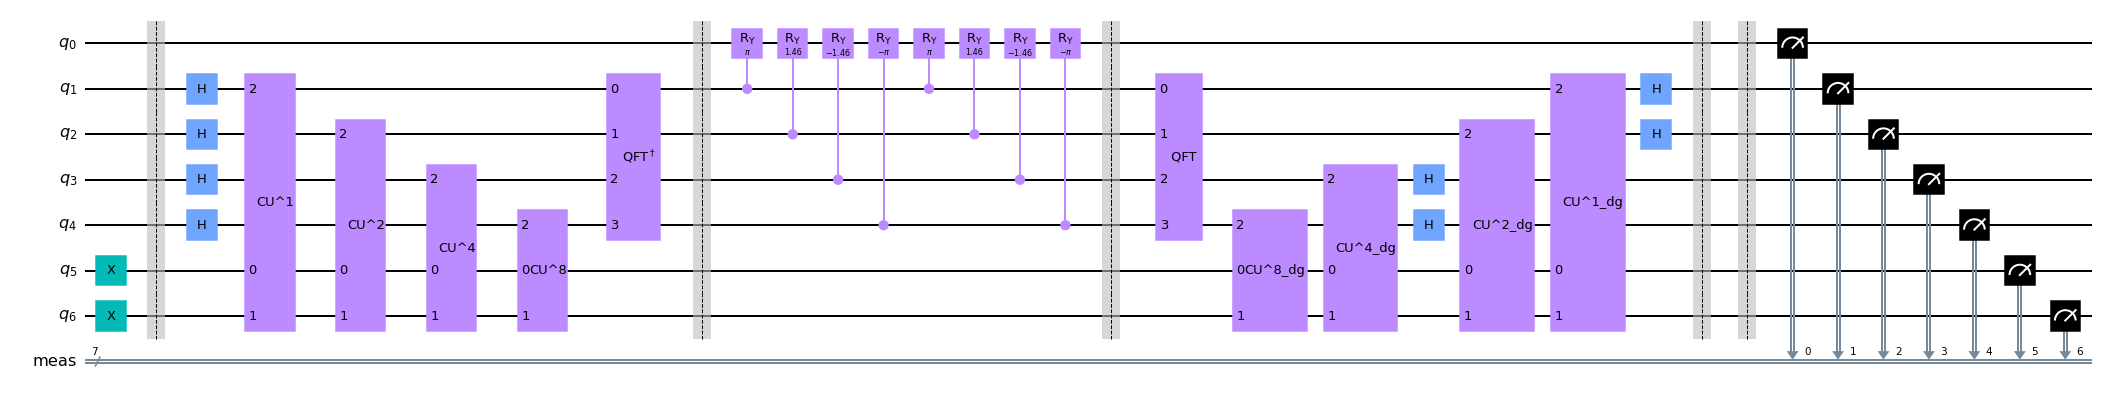

In [17]:
t = (1/8)*np.pi
a,b,c = 1,4,2

def CU(A,num):
    qc = QuantumCircuit(3)
    U_A, C_U = np.eye(4, dtype='complex'), np.eye(8, dtype='complex')
    for i in range(num): U_A = U_A.dot(expm(1j*A*t))
    C_U[4:8,4:8] = U_A 

    qc.unitary(Operator(C_U), range(3))
    CU_gate = qc.to_gate()
    CU_gate.name = "CU^{}".format(num)
    return CU_gate

qc = QuantumCircuit(a+b+c)
qc.x([a+b,a+b+1])

qc.barrier()

for i in range(b): qc.h(a+i)

rep = 1
for i in range(b):
    qc.append(CU(matrix,rep),[a+b,a+b+1,i+1])
    rep*=2
  
qft_dagger(qc,b,a)
qc.barrier()

qc.cry(2*np.arcsin(3/3),1,0)
qc.cry(2*np.arcsin(2/3),2,0)
qc.cry(2*np.arcsin(-2/3),3,0)
qc.cry(2*np.arcsin(-3/3),4,0)

##### repeat 2 times

qc.cry(2*np.arcsin(3/3),1,0)
qc.cry(2*np.arcsin(2/3),2,0)
qc.cry(2*np.arcsin(-2/3),3,0)
qc.cry(2*np.arcsin(-3/3),4,0)

# qc.cry(2*np.arcsin(1/1),1,0)
# qc.cry(2*np.arcsin(1/2),2,0)
# qc.cry(2*np.arcsin(1/4),3,0)
# qc.cry(2*np.arcsin(1/8),4,0)

qc.barrier()

qft(qc,b,a)
rep = 2**(b-1)
for i in range(b):
    qc.append(CU(matrix,int(rep)).inverse(),[a+b,a+b+1,b-i])
    rep/=2 

for i in range(b): qc.h(a+i)

qc.save_statevector()
qc.measure_all()

qc.draw(output="mpl",fold=-1)

solution: [-0.33333333 -0.16666667]


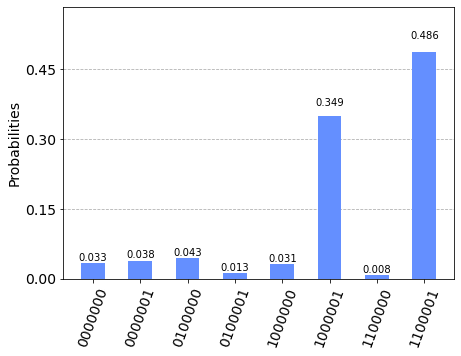

In [18]:
result = execute(qc, backend=backend, shots=4096, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[1], sv[33], sv[65], sv[97]]))
sol_vector = np.real(np.array([sv[1],sv[33]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())

#### Qiskit built-in HHL algorithm

In [19]:
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector

hhl_qc = HHL().construct_circuit(matrix, vector)
hhl_qc.save_statevector()
hhl_qc.measure_all()
hhl_qc.draw(fold=-1)

# hhl_solution = HHL().solve(matrix, vector)
# print(hhl_solution.state.decompose().draw())
# print('Euclidean norm:', hhl_solution.euclidean_norm)

# sv = Statevector(hhl_solution.state).data
# full_vector = np.real(np.array([sv[64], sv[65]]))
# print('solution:', hhl_solution.euclidean_norm*full_vector/np.linalg.norm(full_vector))

┌───────────────┐┌──────┐        ┌─────────┐ ░  ░ ┌─┐                  
q269_0: ┤0              ├┤4     ├────────┤4        ├─░──░─┤M├──────────────────
        │  circuit-5739 ││      │        │         │ ░  ░ └╥┘┌─┐               
q269_1: ┤1              ├┤5     ├────────┤5        ├─░──░──╫─┤M├───────────────
        └───────────────┘│      │┌──────┐│         │ ░  ░  ║ └╥┘┌─┐            
q270_0: ─────────────────┤0     ├┤3     ├┤0        ├─░──░──╫──╫─┤M├────────────
                         │  QPE ││      ││  QPE_dg │ ░  ░  ║  ║ └╥┘┌─┐         
q270_1: ─────────────────┤1     ├┤2     ├┤1        ├─░──░──╫──╫──╫─┤M├─────────
                         │      ││      ││         │ ░  ░  ║  ║  ║ └╥┘┌─┐      
q270_2: ─────────────────┤2     ├┤1 1/x ├┤2        ├─░──░──╫──╫──╫──╫─┤M├──────
                         │      ││      ││         │ ░  ░  ║  ║  ║  ║ └╥┘┌─┐   
q270_3: ─────────────────┤3     ├┤0     ├┤3        ├─░──░──╫──╫──╫──╫──╫─┤M├───
                         └──────┘│      │└─────────┘ ░  ░  ║  ║  ║  ║  ║ └╥┘┌─┐
  q271: ─────────────────────────┤4     ├────────────░──░──╫──╫──╫──╫──╫──╫─┤M├
                                 └──────┘            ░  ░  ║  ║  ║  ║  ║  ║ └╥┘
meas: 7/═══════════════════════════════════════════════════╩══╩══╩══╩══╩══╩══╩═
                                                           0  1  2  3  4  5  6

solution: [-0.33333333  0.16666667]


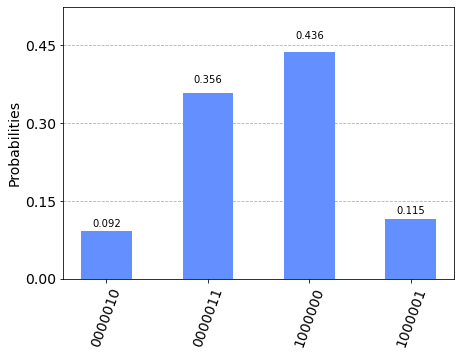

In [20]:
result = execute(hhl_qc, backend=backend, shots=4096, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[64], sv[65]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())